# Practical work 7: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+NomImageBase[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(NomImageBase[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [23]:
import math

def quantize(v, k):
    """ float -> int 
    """
    if v == 1:
        return k-1
    else:
        return math.floor(v * k)
    

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [68]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    Iq = np.zeros(I.shape)
    hist = np.zeros((nH,nS,nV))
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            h,s,v = quantize(I[i,j,0], nH),quantize(I[i,j,1], nS),quantize(I[i,j,2], nV)
            Iq[i,j] = (h,s,v) 
            hist[h,s,v] += 1
    
    return Iq, hist

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [74]:
def normalize(H):
    """ Array -> Array"""
    L2norm = np.linalg.norm(H, 2)
    return H/L2norm

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


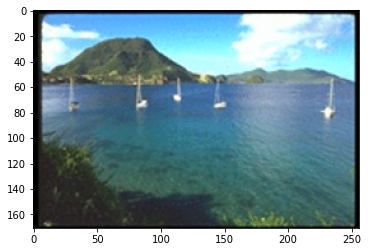

239.0625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


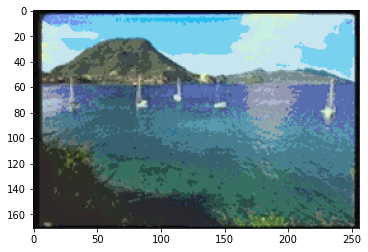

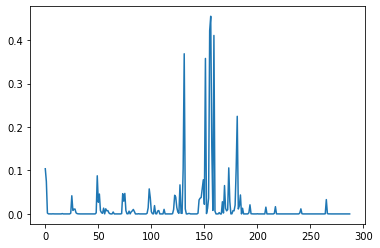

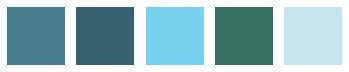

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [76]:

PathImage = './Base/'  # to be completed
nom = 'Paysages67.png'  # to be completed

# quantization parameters
nH = 12 # to be completed
nS = 3 # to be completed
nV = 8 # to be completed


filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

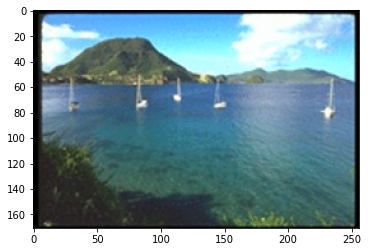

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233.75000000000003


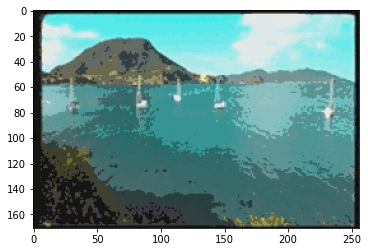

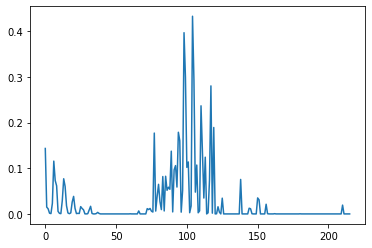

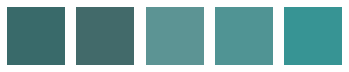

[(1, 5, 2), (1, 4, 2), (1, 4, 3), (1, 5, 3), (1, 7, 3)]


In [77]:
PathImage = './Base/'  # to be completed
nom = 'Paysages67.png'  # to be completed

# quantization parameters
nH = 3 # to be completed
nS = 12 # to be completed
nV = 6 # to be completed


filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

7) What can you say about the results?

Plus de saturation car S a bcp de possibilité ? (rephrase)

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [78]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = True # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation ... it may take a while ...
Textures48.png
Ours__67.png
Voitures92.png
Textures95.png
Avions100.png
Voitures61.png
Voitures76.png
Paysages97.png
Portraits68.png
Avions58.png
Fleche32.png
Avions62.png
Textures26.png
Bestioles15.png
Liontigre72.png
Bestioles32.png
Fleche42.png
Avions98.png
Ours__46.png
Textures50.png
Avions19.png
Textures12.png
Elephant37.png
Avions28.png
Paysages34.png
Ours__11.png
Bestioles5.png
Aeriennes24.png
Voitures82.png
Paysages31.png
Portraits64.png
Liontigre5.png
Voitures85.png
Voitures40.png
Paysages41.png
Ours__43.png
Bestioles59.png
Elephant41.png
Voitures69.png
Bestioles8.png
Elephant92.png
Ours__34.png
Sunsets82.png
Sunsets68.png
Liontigre89.png
Textures27.png
Textures41.png
Ours__54.png
Liontigre53.png
Liontigre103.png
Sunsets63.png
Textures102.png
Portraits65.png
Voitures36.png
Liontigre84.png
Textures125.png
Bestioles4.png
Fleche39.png
Aeriennes12.png
Elephant42.png
Aeriennes28.png
Voitures7.png
Fleche19.png
Textures151.pn

Bestioles14.png
Paysages90.png
Elephant94.png
Paysages13.png
Portraits29.png
Aeriennes19.png
Ours__26.png
Paysages52.png
Liontigre68.png
Ours__37.png
Paysages80.png
Paysages33.png
Paysages37.png
Fleche37.png
Ours__35.png
Sunsets57.png
Liontigre33.png
Voitures64.png
Bestioles58.png
Liontigre12.png
Fleche33.png
Bestioles44.png
Bestioles6.png
Textures66.png
Sunsets76.png
Avions96.png
Voitures53.png
Elephant63.png
Ours__39.png
Textures69.png
Bestioles56.png
Voitures90.png
Voitures47.png
Sunsets92.png
Textures174.png
Paysages50.png
Textures93.png
Fleche5.png
Paysages83.png
Paysages11.png
Textures57.png
Paysages1.png
Sunsets91.png
Liontigre2.png
Sunsets80.png
Paysages81.png
Avions49.png
Paysages68.png
Textures145.png
Ours__15.png
Voitures62.png
Elephant30.png
Liontigre80.png
Voitures29.png
Paysages28.png
Voitures22.png
Textures141.png
Liontigre50.png
Fleche15.png
Paysages30.png
Fleche6.png
Elephant91.png
Ours__8.png
Avions70.png
Elephant4.png
Paysages14.png
Voitures74.png
Avions60.png
Textur

### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [126]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

### you code below
def similarityMatrix():
    sm = np.zeros((listHisto.shape[0], listHisto.shape[0]))
    for i in range(len(listHisto)):
        for j in range(i+1,len(listHisto)):
            diff = abs(listHisto[i] - listHisto[j])
            if(diff < 0.1).all():
                sm[i,j] = 1
    return sm

m = similarityMatrix()
print(m)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [130]:
print(np.sum(m > 0))
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        if (m[i,j]==1):
            print(i,j)

191
10 16
10 57
10 94
10 566
10 573
10 679
10 826
10 828
10 834
10 897
10 972
10 998
14 124
14 502
16 57
16 94
16 566
16 573
16 679
16 826
16 828
16 834
16 897
16 972
16 998
19 623
21 477
57 94
57 566
57 573
57 679
57 826
57 828
57 834
57 897
57 972
57 998
70 169
70 361
70 387
70 441
70 824
70 864
70 905
84 599
94 566
94 573
94 679
94 826
94 828
94 834
94 897
94 972
94 998
102 860
108 935
112 511
155 807
160 688
169 361
169 387
169 441
169 824
169 864
169 905
184 187
186 261
186 402
186 539
186 628
186 650
186 718
186 969
191 327
191 693
205 381
205 507
205 518
212 566
212 573
212 826
261 402
261 539
261 628
261 650
261 718
261 969
281 766
283 583
301 646
305 970
327 693
336 662
345 822
361 387
361 441
361 824
361 864
361 905
373 964
381 507
381 518
387 441
387 824
387 864
387 905
393 432
393 436
393 447
402 539
402 628
402 650
402 718
402 969
412 578
419 511
424 587
432 436
432 447
439 611
439 1022
441 824
441 864
441 905
471 858
471 962
471 996
471 1020
480 993
507 518
539 628
539 65

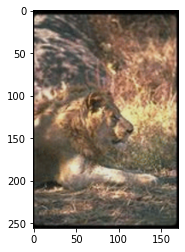

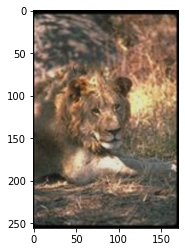

In [133]:
plt.imshow(Image.open(pathImage+(listImage[184]).strip()))
plt.show()
plt.imshow(Image.open(pathImage+(listImage[187]).strip()))
plt.show()

2. Display the matrix `S`  as an image. What can we say about this it ?

Your answer: ..................

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

In [ ]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+NomImageBase[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


In [ ]:
import random


5. What can you say about the results ? What are the limitations and the advantages of this method ?

Your answer: ..........